# JLS Bubble Detector - v1 (WIP)

*This version: 6 October 2018*

This is an annotated, work-in-progress attempt to build and test the bubble detector (and associated tech) in Gerlach, Demos, and Sornette (2018) (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164246).

Doing this involves:

1. Grabbing a time series of prices for the web
2. Fitting an equation that supposedly describes when bubbles begin and end
3. Creating forecasting indicators from a bunch of fits and other criteria
4. Evaluating the performance of the resulting system

Steps (1) and (2) are done. But I'm currently stuck in a - temporary hopefully! - motivational rut with starting (3). **I've written this so that you can see what I've done so far and get up to speed for when I'm out of the doldrums.**

### 0. Importing the Python packages used in this project

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, solve, det
from scipy.optimize import leastsq

### 1. Getting a time series of prices

Price data come from the Alpha Vantage API (https://www.alphavantage.co/). It's free and great to use.

The next bit of code pulls the entire time series of prices for an example company (Facebook) and puts it into a 'dataframe' (Python's equivalent of an Excel spreadsheet).

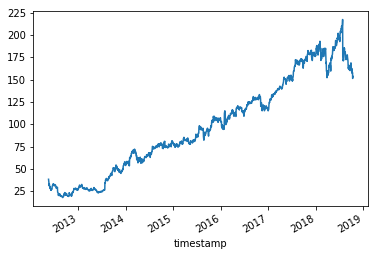

In [3]:
# Request the data

r = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=83SCGSM1BQW0WE86&datatype=csv')
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=FB&outputsize=full&apikey=83SCGSM1BQW0WE86&datatype=csv'

# Format and save to .csv so we don't need to keep querying for it

source = requests.get(url).content.decode().split("\n") # Formats the .csv file into something we can use
df = pd.read_csv(url, index_col=0, parse_dates=True) # Reads in the .csv file
df.to_csv('FBprices.csv')

# What we have:

df['close'].plot() 
plt.show() # This and the line above plot closing prices

### 2. Fitting a 'Log-Periodic Power Law Singularity' (LPPLS) model to the time series of prices

The heart of this project is an equation that describes two features of some speculative bubbles seen in financial data:

1. Prices accelerate at a faster-than-exponential rate
2. Prices show an increasing frequency of volatility fluctuations 

These two features are derived from a theory by Sornette (1995) and Johansen et al. (1999, 2000) - this is where the 'JLS' comes from - that use ideas from forecasting earthquakes. 

Here is a TED talk by Sornette about it and 'predicting the next financial crisis': https://www.ted.com/talks/didier_sornette_how_we_can_predict_the_next_financial_crisis?language=en. One goal of this project is to see for ourselves whether ths is true!

And here's the equation:

$$ E(ln(p(t)) = A + (t_{c}-t)^{m}(B+C_{1}\cos(\omega\ln(t_{c}-t))+C_{2}\sin(\omega\ln(t_{c}-t))) $$

There are seven parameters to estimate:

* Four linear parameters: $A$, $B$, $C_{1}$ and $C_{2}$
* Three non-linear parameters: $m$, $\omega$, and $t_{c}$

The key parameter is $t_{c}$, which is when the bubble is expected to pop.

Estimating this equation is rather involved. It happens in two steps:

1. Estimates for the linear parameters (for a given set of non-linear params) are found using OLS, which produces closed-form expressions for these
2. Estimates for the non-linear parameters are found using non-linear least squares and the Levenberg-Marquadt algorithm

Code for this is below. (You may remember that it took me a few tries to get this working!) And here is a link to the textbook which I used to write up the LM algorithm for NLS: http://vmls-book.stanford.edu/

In [52]:
## Load dataset obtained earlier

df = pd.read_csv('FBprices.csv', index_col=0, parse_dates=True)

#Start with the approach from Attempt 2

## Variables

# Intercept (column vector of ones)

df['const'] = 1

# Time counter

df['t'] = list(reversed(range(len(df['const']))))

# Initial values

tc = len(df['const'])+1 # tomorrow
m = 0.5 # within recommended filter bound
ω = 10 # within recommended filter bound

# Definitions and functions

const = np.array(df['const'])
x0 = np.array([tc,m,ω])
t = np.array(df['t'])
p = np.array(df['close']).T
y = np.log(p)

def f(x0, t):
    return x0[0] - t**x0[1]

def g(x0, t):
    return ((x0[0]-t)**x0[1])*np.cos(x0[2]*np.log(x0[0]-t))
               
def h(x0,t):
    return ((x0[0]-t)**x0[1])*np.sin(x0[2]*np.log(x0[0]-t))

def X(const, x0, t):
    return np.array([const, f(x0,t), g(x0,t), h(x0,t)]).T

def β_hat(const, x0, t):
    return inv(X(const, x0, t).T @ X(const, x0, t)) @ X(const, x0, t).T @ y

def residual(const, x0, t):
    
    A_hat = const*β_hat(const,x0,t)[0]
    B_hat = β_hat(const,x0,t)[1]
    C_1_hat = β_hat(const,x0,t)[2]
    C_2_hat = β_hat(const,x0,t)[3]
    
    return y - A_hat - B_hat*f(x0,t) - C_1_hat*g(x0,t) - C_2_hat*h(x0,t)

## Non-linear least squares

# Approximating the Jacobian via finite differences

δ = 0.0001 #adjustable perturbation

tc_perturb_plus = np.array([tc+δ,m,ω])
tc_perturb_minus = np.array([tc-δ,m,ω])
m_perturb_plus = np.array([tc,m+δ,ω])
m_perturb_minus = np.array([tc,m-δ,ω])
ω_perturb_plus = np.array([tc,m,ω+δ])
ω_perturb_minus = np.array([tc,m,ω-δ])

def J(const, x0, t):
    
    tc_dev = (residual(const, tc_perturb_plus, t) - residual(const, tc_perturb_minus, t)) / 2*δ
    m_dev = (residual(const, m_perturb_plus, t) - residual(const, m_perturb_minus, t)) / 2*δ
    ω_dev = (residual(const, ω_perturb_plus, t) - residual(const, ω_perturb_minus, t)) / 2*δ
    
    return np.array([tc_dev, m_dev, ω_dev]).T
    
# Levenberg-Marquardt algorithm

def LM(const, x0, t):
    
    iterations = 100 # adjust this as needed
    λ = 1 # initial damping parameter
    ssr0 = (residual(const, x0, t)**2).sum() # initial sum of squared residuals
    i =0

    while i<iterations:
        x1 = x0 - (inv(J(const, x0, t).T @ J(const, x0, t) + λ*np.identity(3)) @ J(const, x0, t).T @ residual(const, x0, t)) # tentative iterate
        ssr1 = (residual(const, x1, t)**2).sum()
        if ssr1 < ssr0:
            λ = 0.8*λ
            x0 = x1
            ssr0 = ssr1
            i = i+1
        else:
            λ = 2*λ
            ssr0 = ssr1
    
    return np.array([β_hat(const,x0,t), x0, ssr0])  #Estimates of A_hat, B_hat, C_1_hat, C_2_hat, tc, m, ω and SSR

x0_LM = LM(const,x0,t)[1]

Here is a plot of the prices and our fitted equation:



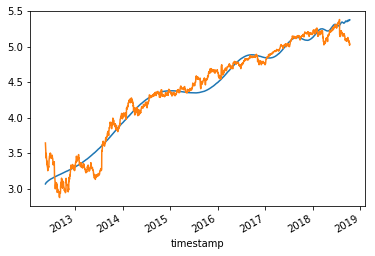

In [61]:
## Plotting the results

data['y_hat'] = const*β_hat(const,x0_LM,t)[0] + β_hat(const,x0_LM,t)[1]*f(x0_LM,t) + β_hat(const,x0_LM,t)[2]*g(x0_LM,t) + β_hat(const,x0_LM,t)[3]*h(x0_LM,t)
data['y'] = y

data['y_hat'].plot()
data['y'].plot()
plt.show()

### 3. Creating ex-ante bubble indicators: the LPPLS Confidence Indicator and ensemble forecasting

What we've done is cool, but doesn' have much practical value at the moment. This is because it doesn't really make sense to characterise the entire FB price series as one giant bubble.

The predictive value of doing this isn't obvious. One thing I often wonder about is how the LPPLS equation can predict prices - already a very eyebrow-raising claim - when it can be fit to *any* time series, and when the data for it to get a good fit are only there for use when the bubble has already happened.

Gerlach, Demos, and Sornette's (2018) solution to this (see the foundation paper at the top of this note) - which underpins what their Financial Crisis Observatory does - has two parts. The first is create a risk indicator of when something is becoming a bubble. The risk indicator is called the 'LPPLS Confidence Indicator'. It's constructed by defining what a 'qualifying' bubble should look like, and then repeatedly fitting the LPPLS model to different time windows to see whether the estimates start looking suspiciously like this. Specifically, they:

1. Define qualifying values for what 'legitimate' bubble parameters are (see Table 2 on page 19 of their paper and other filtering criteria p. 7). Estimates that fall outside these ranges are struck out.
2. Take a rolling time window, e.g. the past 30-120 days, and fit the LPPLS model to each of these (the last 120, 119, 118... up to the last 30 days) windows.
3. Calculate the fraction of fits that 'qualify' - the higher the fraction, the more likely a bubble is happening. This fraction is the 'LPPLS Confidence Indicator'.

Building this would be a big milestone for this project. If we had these confidence measures, we could then ask questions like 'when does an estimate of $t_{c}$ become stable?' or 'what level of confidence % should we buy at or get out at / warn others about?'

The second thing the authors do is to forecast when a bubble will burst. They do this using a 'k-means' clustering method which I don't understand right now.

**This is where the project is up to at the time of writing.** I've had a bit of trouble learning to work with times and dates in Python and doing repeated fits, but those are the next steps.

In [82]:
## Running everything for the last 30 days - repeats a lot of the above code (I'll sort this out later)

data = pd.read_csv('FBprices.csv', index_col=0, parse_dates=True) # load master data

dstore = pd.DataFrame(columns=['A_hat','B_hat','C_1_hat','C_2_hat','tc','m','ω']) # a place to store results

for i in range(30,121): # 30,121 took 3m 21s to run
    
    # Takes the relevant dates
    
    df = data.head(i).copy()
    
    # LPPLS estimates (recomputing some things to be safe)
    
    df['const'] = 1
    df['t'] = list(reversed(range(len(df['const']))))

    tc = len(df['const'])+1
    m = 0.5
    ω = 10

    const = np.array(df['const'])
    x0 = np.array([tc,m,ω])
    t = np.array(df['t'])
    p = np.array(df['close']).T
    y = np.log(p)

    tc_perturb_plus = np.array([tc+δ,m,ω])
    tc_perturb_minus = np.array([tc-δ,m,ω])
    m_perturb_plus = np.array([tc,m+δ,ω])
    m_perturb_minus = np.array([tc,m-δ,ω])
    ω_perturb_plus = np.array([tc,m,ω+δ])
    ω_perturb_minus = np.array([tc,m,ω-δ])

    x0_LM = LM(const,x0,t)[1]

    # Store results w index 1

    dstore.loc[i, ['A_hat']] = β_hat(const,x0_LM,t)[0]
    dstore.loc[i, ['B_hat']] = β_hat(const,x0_LM,t)[1]
    dstore.loc[i, ['C_1_hat']] = β_hat(const,x0_LM,t)[2]
    dstore.loc[i, ['C_2_hat']] = β_hat(const,x0_LM,t)[3]
    dstore.loc[i, ['tc']] = x0_LM[0]
    dstore.loc[i, ['m']] = x0_LM[1]
    dstore.loc[i, ['ω']] = x0_LM[2]

dstore # final dataset

# Plotting code to see each fit

# df['y_hat'] = const*β_hat(const,x0_LM,t)[0] + β_hat(const,x0_LM,t)[1]*f(x0_LM,t) + β_hat(const,x0_LM,t)[2]*g(x0_LM,t) + β_hat(const,x0_LM,t)[3]*h(x0_LM,t)
#df['y'] = y

#df['y_hat'].plot()
#df['y'].plot()
#plt.show()

,A_hat,B_hat,C_1_hat,C_2_hat,tc,m,ω
30,4.73999,0.0129835,-0.00159458,0.000247997,30.9902,0.548603,9.97103
31,4.5819,0.0179835,-0.00218832,0.00019822,32.0005,0.500278,9.95376
32,4.77276,0.0115516,-0.00190065,0.000127366,33.0015,0.621714,9.94511
33,4.80797,0.0102562,-0.00183223,0.000113453,34.0036,0.661465,9.93686
34,4.7605,0.0115338,-0.00198266,0.000103797,35.0085,0.643828,9.92794
35,4.9434,0.0059054,-0.00136417,7.67089e-05,36.0099,0.812218,9.91219
36,5.02068,0.00353593,-0.00099494,9.55237e-05,37.009,0.940787,9.89885
37,4.99965,0.00413083,-0.00110188,0.000136759,38.0091,0.902894,9.89356
38,5.01771,0.00359557,-0.000993842,0.000139732,39.0117,0.939348,9.88217
39,5.01053,0.00378595,-0.00101164,0.000157925,40.0137,0.928678,9.87608


In [6]:
# Current working problems


# (DONE) Run for last 30 days
# Store these results
# Run for last 31 days; store
# ...
# Run for last 120 days; store
# Calculate the fraction and store this in a separate dataset


# Put the current estimates into one row of a dataframe
# Run LM for a subset of the current dataframe; index that run to a unique marker
# Store the estimates of that run into a dataframe
# Index LPLSS to the a unique marker
# Export the dataframe as a .csv

# Df query to get the dates (remember how to do this) from one dataframe
# Put this into another datframe
# Then do the estimation, put it out

## Pseudo-code for next steps

# Restrict the data to one of the dt \in [30,120] day windows
# Fit a LPPLS curve to this window
# Do a check to see if the parameters pass the filter conditions in Table 2 of the paper
# Fill a container variable with 1 if so; 0 otherwise

# Then write a loop that
# Repeats the above for the other 90 windows in the [30,120] period:
# (1) Get a time period
# (2) Fit a LPPLS model
# (3) Do the check and fill a container variable

# Then report the LPPLS Confidence Indicator as the sum of 1s in the container variable divided by the periods (91)

# Then write another loop which does this for different days - lots of computation time here!

## Changes and additions needed to the existing code to facilitate the above

# 1. Package up the LPPLS bit into a function - ideally want to be able to plug in a timeframe and go
# [Up to here]